In [1]:
import pandas as pd
pd.set_option('max_colwidth', None)
import numpy as np
from scipy.stats import mannwhitneyu
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
sns.set(font_scale=1.2)

# Анализ A/B-теста по увеличению выручки интернет-магазина

- [Описание проекта](#project_description)
- [Загрузка и подготовка данных](#data_upload_and_preparation)
- [Часть 1. Приоритизация гипотез](#hypotheses_prioritization)
    - [Фреймворк ICE](#ICE)
    - [Фреймворк RICE](#RICE)
- [Часть 2. Анализ A/B-теста](#AB_test_analysis)
    - [Кумулятивная выручка](#cumulative_revenue)
    - [Кумулятивное количество заказов](#cumulative_orders)
    - [Кумулятивный средний чек](#cumulative_avg_revenue)
    - [Кумулятивная конверсия](#cumulative_conversion)
    - [Аномалии](#outliers)
    - [Гипотеза о разнице в конверсии](#hypothesis_1)
    - [Гипотеза о разнице в среднем чеке](#hypothesis_2)
- [Выводы](#conclusions)

## Описание проекта <a name='project_description'></a>

Вместе с отделом маркетинга нужно подготовить и приоритизировать гипотезы по увеличению выручки крупного интернет-магазина. Затем запустить A/B-тест и проанализировать результаты.

## Загрузка и подготовка данных <a name='data_upload_and_preparation'></a>

In [2]:
hypothesis = pd.read_csv('datasets/hypothesis.csv')
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [3]:
orders = pd.read_csv('datasets/orders.csv')
orders.rename(columns={'transactionId': 'transaction_id', 'visitorId': 'visitor_id'}, inplace=True)
orders.head()

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [4]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   transaction_id  1197 non-null   int64 
 1   visitor_id      1197 non-null   int64 
 2   date            1197 non-null   object
 3   revenue         1197 non-null   int64 
 4   group           1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [5]:
orders['date'] = pd.to_datetime(orders['date'])

In [6]:
visitors = pd.read_csv('datasets/visitors.csv')
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [7]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [8]:
visitors['date'] = pd.to_datetime(visitors['date'])

In [9]:
visitors['date'].agg(['min', 'max'])

min   2019-08-01
max   2019-08-31
Name: date, dtype: datetime64[ns]

In [10]:
visitors.groupby('group')['visitors'].sum()

group
A    18736
B    18916
Name: visitors, dtype: int64

В течение месяца был проведен сбалансированный A/B-тест.

In [11]:
visitors_groups = orders.groupby('visitor_id')['group'].nunique()
sum(visitors_groups == 2) / len(visitors_groups)

0.05625606207565471

Система сплитования сработала не совсем корректно, в результате чего некоторые пользователи попали в обе группы. Чем оставлять, удалим этих пользователей, так как их немного и это несильно повлияет на точность информации о количестве пользователей в таблице `visitors`. Но все равно это не очень хорошая практика и лучше заранее проверять систему сплитования, чтобы не возникало такой ситуации.

In [12]:
orders = orders[orders['visitor_id'].isin(visitors_groups[visitors_groups == 1].index)]

## Часть 1. Приоритизация гипотез <a name='hypotheses_prioritization'></a>

### Фреймворк `ICE` <a name='ICE'></a>

$ICE = \frac{Impact \; \times \; Confidence}{Efforts}$

In [13]:
hypothesis['ICE'] = (hypothesis['Impact'] * hypothesis['Confidence']) / hypothesis['Efforts']

In [14]:
hypothesis.drop(columns='Reach').sort_values(by='ICE', ascending=False).round(3)

,Hypothesis,Impact,Confidence,Efforts,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",9,9,5,16.200
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",10,8,6,13.333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",7,8,5,11.200
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",3,8,3,8.000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",3,7,3,7.000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",5,4,10,2.000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",2,2,3,1.333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",3,3,8,1.125
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1,1,1,1.000


Самые перспективные гипотезы по `ICE`: 0, 2, 6, 7 и 8

### Фреймворк `RICE` <a name='RICE'></a>

$RICE = \frac{Rearch \; \times \; Impact \; \times \; Confidence}{Efforts}$

In [15]:
hypothesis['RICE'] = (hypothesis['Reach'] * hypothesis['Impact'] * hypothesis['Confidence']) / hypothesis['Efforts']

In [16]:
hypothesis.sort_values(by='RICE', ascending=False).round(3)

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.333,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000,3.0


По `RICE` перспективные гипотезы такие же, только изменились их приоритеты. Гипотеза 8, считавшаяся самой перспективной по `ICE`, заняла 5 место, так как почти не имеет влияния на пользователей. Большой охват пользователей вывел в топ гипотезы 2 и 7, ранее занимавшие 3 и 5 места по `ICE`.

## Часть 2. Анализ A/B-теста <a name='AB_test_analysis'></a>

### Кумулятивная выручка <a name='cumulative_revenue'></a>

In [17]:
orders['day'] = orders['date'].dt.day
visitors['day'] = visitors['date'].dt.day

dates_groups = orders[['day', 'group']].drop_duplicates() 
orders_aggregated = (
    dates_groups
    .apply(
        lambda x: orders[(orders['day'] <= x['day']) & (orders['group'] == x['group'])]
        .agg({'day': 'max', 'group': 'max', 'transaction_id': 'count', 'visitor_id': 'nunique', 'revenue': 'sum'}), 
        axis=1
    )
    .sort_values(by=['day', 'group'])
)
orders_aggregated.rename(columns={'transaction_id': 'orders', 'visitor_id': 'buyers'}, inplace=True)

visitors_aggregated = (
    dates_groups
    .apply(
        lambda x: visitors[(visitors['day'] <= x['day']) & (visitors['group'] == x['group'])]
        .agg({'day': 'max', 'group': 'max', 'visitors': 'sum'}),
        axis=1
    )
    .sort_values(by=['day', 'group'])
)

cumulative_data = orders_aggregated.merge(visitors_aggregated, on=['day', 'group'])
cumulative_data['avg_revenue'] = cumulative_data['revenue'] / cumulative_data['orders']

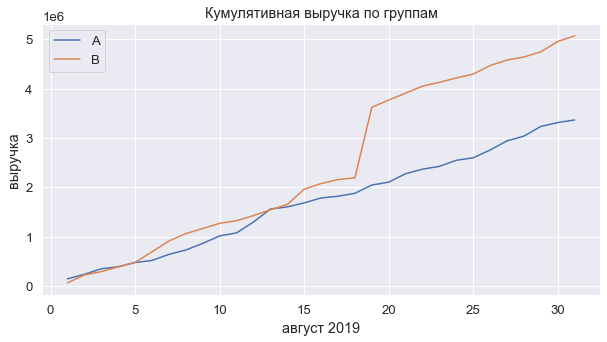

In [18]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=cumulative_data, x='day', y='revenue', hue='group')
plt.xlabel('август 2019')
plt.ylabel('выручка')
plt.title('Кумулятивная выручка по группам')
plt.legend(title=None);

* Выручка равномерно растет, за исключением резкого скачка у группы B с 18 по 19 день

* В течение теста выручка в основном больше у группы B

### Кумулятивное количество заказов <a name='cumulative_orders'></a>

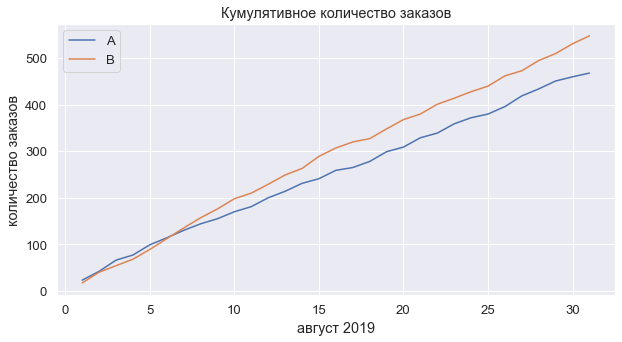

In [19]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=cumulative_data, x='day', y='orders', hue='group')
plt.xlabel('август 2019')
plt.ylabel('количество заказов')
plt.title('Кумулятивное количество заказов')
plt.legend(title=None);

* В первую неделю количество заказов у группы B немного меньше. Со второй недели и до конца месяца разница постепенно увеличивается в пользу группы B

* Нет всплеска числа заказов с 18 по 19 день, получается резкий скачек выручки у группы B обусловлен дорогими заказами



### Кумулятивный средний чек <a name='cumulative_avg_revenue'></a>

In [20]:
cumulative_avg_revenue_A = cumulative_data.loc[cumulative_data['group'] == 'A', ['day', 'avg_revenue']]
cumulative_avg_revenue_B = cumulative_data.loc[cumulative_data['group'] == 'B', ['day', 'avg_revenue']]
cumulative_avg_revenue = cumulative_avg_revenue_A.merge(cumulative_avg_revenue_B, on='day', suffixes=['_A', '_B'])

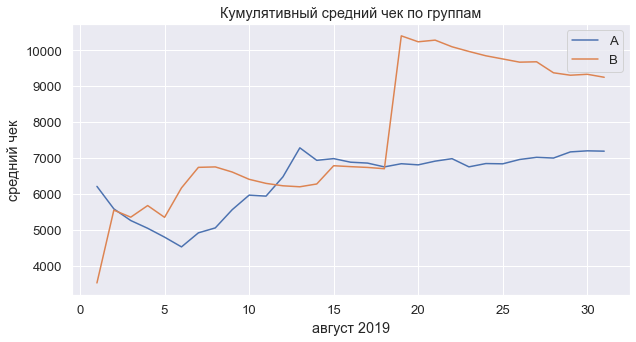

In [21]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=cumulative_data, x='day', y='avg_revenue', hue='group')
plt.xlabel('август 2019')
plt.ylabel('средний чек')
plt.title('Кумулятивный средний чек по группам')
plt.legend(title=None);

До 19 августа средний чек нестабилен в обеих группах. Далее у котрольной группы он более-менее установился около 7000, а у тестовой группы после резкого скачка наблюдается отрицательный тренд.

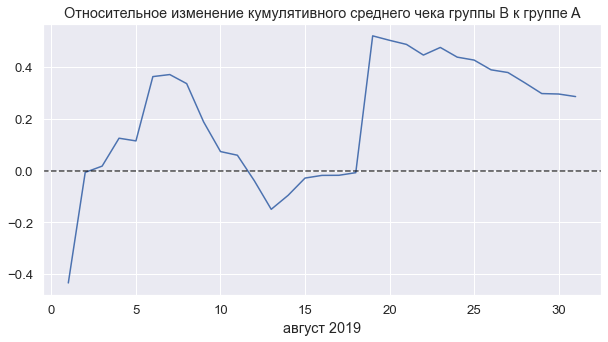

In [22]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, 32), cumulative_avg_revenue['avg_revenue_B'] / cumulative_avg_revenue['avg_revenue_A'] - 1)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.7)
plt.xlabel('август 2019')
plt.title('Относительное изменение кумулятивного среднего чека группы B к группе A');

Много резких изменений до 19 августа, после наблюдается тренд на снижение отношения среднего чека.

### Кумулятивная конверсия <a name='cumulative_conversion'></a>

In [23]:
cumulative_data['conversion'] = cumulative_data['orders'] / cumulative_data['visitors']

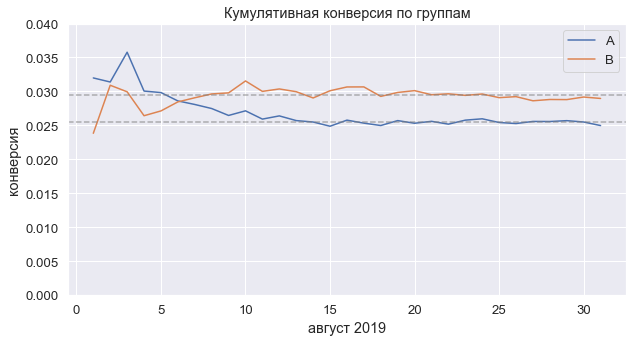

In [24]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=cumulative_data, x='day', y='conversion', hue='group')
plt.axhline(y=0.0255, color='grey', linestyle='--', alpha=0.6)
plt.axhline(y=0.0295, color='grey', linestyle='--', alpha=0.6)
plt.xlabel('август 2019')
plt.ylabel('конверсия')
plt.ylim(0, 0.04)
plt.title('Кумулятивная конверсия по группам')
plt.legend(title=None);

Конверсии зафиксировались около 26% и 30% у групп A и B.

In [25]:
cumulative_conversion_A = cumulative_data.loc[cumulative_data['group'] == 'A', ['day', 'conversion']]
cumulative_conversion_B = cumulative_data.loc[cumulative_data['group'] == 'B', ['day', 'conversion']]
cumulative_conversion = cumulative_conversion_A.merge(cumulative_conversion_B, on='day', suffixes=['_A', '_B'])

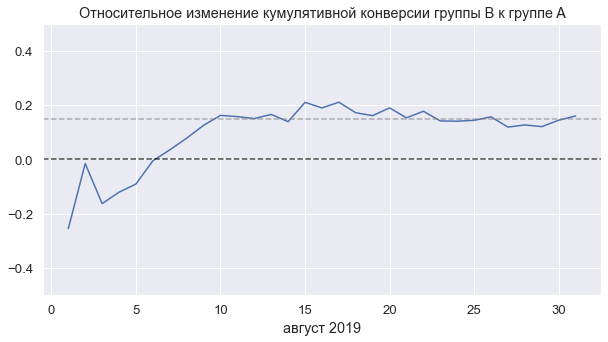

In [26]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, 32), cumulative_conversion['conversion_B'] / cumulative_conversion['conversion_A'] - 1)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.7)
plt.axhline(y=0.15, color='grey', linestyle='--', alpha=0.6)
plt.xlabel('август 2019')
plt.ylim(-0.5, 0.5)
plt.title('Относительное изменение кумулятивной конверсии группы B к группе A');

У группы B конверсия была хуже только первые 5 дней. Дальше конверсия группы B вырвалась вперед и начиная с середины второй недели была в среднем больше конверсии группы A на 15%.

### Аномалии <a name='outliers'></a>

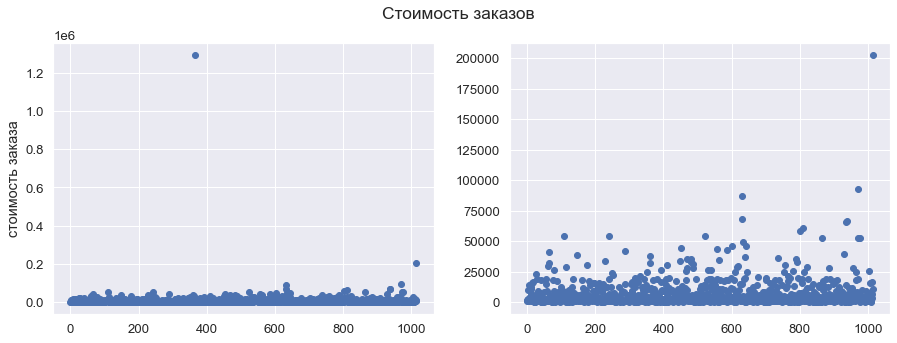

In [27]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
axes[0].scatter(x=range(len(orders)), y=orders['revenue'])
axes[0].set_ylabel('стоимость заказа')
axes[1].scatter(x=range(sum(orders['revenue'] < 10**6)), y=orders.loc[orders['revenue'] < 10**6,'revenue'])
plt.suptitle('Стоимость заказов');

In [28]:
orders['revenue'].quantile([0.9, 0.95, 0.99]).to_frame()

,revenue
0.90,17990.0
0.95,26785.0
0.99,53904.0


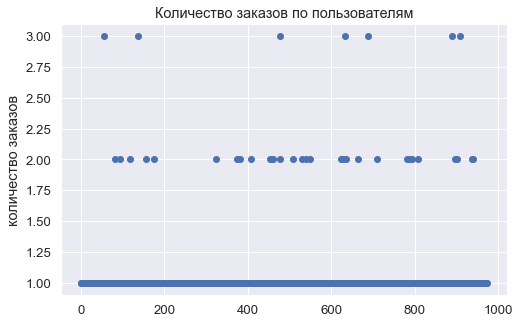

In [29]:
orders_by_visitors = orders.groupby('visitor_id', as_index=False)['transaction_id'].count()
orders_by_visitors.rename(columns={'transaction_id': 'orders'}, inplace=True)

plt.figure(figsize=(8, 5))
plt.scatter(x=range(len(orders_by_visitors)), y=orders_by_visitors['orders'])
plt.ylabel('количество заказов')
plt.title('Количество заказов по пользователям');

In [30]:
orders_by_visitors['orders'].quantile([0.9, 0.95, 0.99]).to_frame()

,orders
0.90,1.0
0.95,1.0
0.99,2.0


Будем считать аномальными пользователями тех, кто совершил заказы дороже 30 тыс. или сделал 3 заказа.

In [31]:
visitors_with_many_orders = orders_by_visitors.loc[orders_by_visitors['orders'] == 3, 'visitor_id']
visitors_with_expensive_orders = orders.loc[orders['revenue'] > 30000, 'visitor_id']
abnormal_visitors = pd.concat([visitors_with_many_orders, visitors_with_expensive_orders], axis=0).drop_duplicates()

In [32]:
print(f'Всего {len(abnormal_visitors)} аномальных пользователей.')

Всего 49 аномальных пользователей.


### Гипотеза о разнице в конверсии <a name='hypothesis_1'></a>

**Нулевая:** кол-во заказов распределено одинаково в группах A и B

**Альтернативная:** кол-во заказов распределено по-разному в группах A и B

#### До удаления аномальных пользователей

In [33]:
cumulative_data_A = cumulative_data.loc[cumulative_data['group'] == 'A', ['day', 'visitors', 'orders', 'revenue']]
cumulative_data_B = cumulative_data.loc[cumulative_data['group'] == 'B', ['day', 'visitors', 'orders', 'revenue']]
cumulative_data_2 = cumulative_data_A.merge(cumulative_data_B, on='day', suffixes=['_A', '_B'])

orders_by_visitors = orders.groupby(['visitor_id', 'group'], as_index=False)['transaction_id'].count()
orders_by_visitors.rename(columns={'transaction_id': 'orders'}, inplace=True)
orders_by_visitors_A = orders_by_visitors[orders_by_visitors['group'] == 'A']
orders_by_visitors_B = orders_by_visitors[orders_by_visitors['group'] == 'B']

orders_A = pd.concat([orders_by_visitors_A['orders'], pd.Series(0, index=np.arange((cumulative_data_2.loc[cumulative_data_2['day'] == 31, 'visitors_A'] - len(orders_by_visitors_A['orders'])).values), name='orders')], axis=0)
orders_B = pd.concat([orders_by_visitors_B['orders'], pd.Series(0, index=np.arange((cumulative_data_2.loc[cumulative_data_2['day'] == 31, 'visitors_B'] - len(orders_by_visitors_B['orders'])).values), name='orders')], axis=0)

In [34]:
statistic, p_value = mannwhitneyu(orders_A, orders_B, alternative='two-sided')
print(f'p-value: {p_value}')
print(f'Относительный прирост среднего числа заказов группы B: {orders_B.mean() / orders_A.mean() - 1}')

p-value: 0.011018084110014696
Относительный прирост среднего числа заказов группы B: 0.1597977924896936


#### После удаления аномальных пользователей

In [35]:
orders_filtered_A = pd.concat([orders_by_visitors_A.loc[~orders_by_visitors_A['visitor_id'].isin(abnormal_visitors), 'orders'], pd.Series(0, index=np.arange((cumulative_data_2.loc[cumulative_data_2['day'] == 31, 'visitors_A'] - len(orders_by_visitors_A['orders'])).values), name='orders')], axis=0)
orders_filtered_B = pd.concat([orders_by_visitors_B.loc[~orders_by_visitors_B['visitor_id'].isin(abnormal_visitors), 'orders'], pd.Series(0, index=np.arange((cumulative_data_2.loc[cumulative_data_2['day'] == 31, 'visitors_B'] - len(orders_by_visitors_B['orders'])).values), name='orders')], axis=0)

statistic, p_value = mannwhitneyu(orders_filtered_A, orders_filtered_B, alternative='two-sided')
print(f'p-value: {p_value}')
print(f'Относительный прирост среднего числа заказов группы B: {orders_filtered_B.mean() / orders_filtered_A.mean() - 1}')

p-value: 0.009707773706615004
Относительный прирост среднего числа заказов группы B: 0.187256954721281


<br>

До и после удаления аномальных пользователей есть статистически значимое различие в конверсии по группам при $\alpha = 5\%$. После удаления аномальных пользователей разница в конверсии между группа увеличилась с 16% до 19%.

### Гипотеза о разнице в среднем чеке <a name='hypothesis_2'></a>

**Нулевая:** распределение чека одинаковое у групп A и B

**Альтернативная:** распределение чека разное у групп A и B

#### До удаления аномальных пользователей

In [36]:
revenue_A = orders.loc[orders['group'] == 'A', 'revenue']
revenue_B = orders.loc[orders['group'] == 'B', 'revenue']

statistic, p_value = mannwhitneyu(revenue_A, revenue_B, alternative='two-sided')
print(f'p-value: {p_value}')
print(f'Относительное различие в среднем чеке между группами {revenue_B.mean() / revenue_A.mean() - 1}')

p-value: 0.8294908998149533
Относительное различие в среднем чеке между группами 0.28660287636871096


Нет оснований считать, что есть статистически значимая разница в среднем чеке. Средний чек группы B на 29% больше среднего чека группы A из-за дорогих заказов в группе B.

#### После удаления аномальных пользователей 

In [37]:
revenue_filtered_A = orders.loc[(~orders['visitor_id'].isin(abnormal_visitors)) & (orders['group'] == 'A'), 'revenue']
revenue_filtered_B = orders.loc[(~orders['visitor_id'].isin(abnormal_visitors)) & (orders['group'] == 'B'), 'revenue']

statistic, p_value = mannwhitneyu(revenue_filtered_A, revenue_filtered_B, alternative='two-sided')
print(f'p-value: {p_value}')
print(f'Относительное различие в среднем чеке между группами {revenue_filtered_B.mean() / revenue_filtered_A.mean() - 1}')

p-value: 0.7408811467812091
Относительное различие в среднем чеке между группами -0.02656692045947706


Нет статистически значимой разницы в среднем чеке. Относительной разницы в среднем чеке уже не балюдается.

## Выводы <a name='conclusions'></a>

* До и после удаления аномалий различие в конверсии статистически значимо, а в среднем чеке – нет

* По графику конверсии видно, что с 6 дня конверсия в группе B стабильно лучше конверсии группы A

* По графику среднего чека разница колеблется и нельзя сделать какие-то выводы

Можно остановить тест и зафиксировать победу группы B.